# Transfer learning / fine-tuning

Este Notebook realiza o transfer learning de uma rede ImageNet para a classificação de gatos e cachorros. Inicialmente, a rede utilizada não possui as classes "gato" e "cachorro", porém, como é uma rede altamente eficiente para classificação de imagens em geral e treinada com milhões de parâmetros e centenas de milhares de imagens, é possível aproveitar este "conhecimento" para retreinar um dataset menor. Isso é possível porque boa parte dos padrões aprendidos pela rede neural são comuns a qualquer tipo de imagem (identificação de bordas, por exemplo). O retreino foi realizado com o dataset cats_vs_dogs disponível no TensorFlow.


Este trabalho é a entrega do Desafio de Projeto do Bootcamp BairesDev - Machine Learning Practitioner da DIO. Parte dele foi baseado no tutorial disponível em https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb.



## Importação das bibliotecas

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

import tensorflow_datasets as tfds
import tensorflow as tf

### Importação do dataset

Foi utilizado o dataset cats_vs_dogs. Maiores informações sobre o dataset podem ser obtidas em https://www.tensorflow.org/datasets/catalog/cats_vs_dogs.
A célula abaixo divide o dataset em treinamento (70%), validação (15%) e teste (15%). Os dados de validação serão utilizados para avaliar o modelo durante o treinamento e os dados de teste serão utilizados para avaliação final do modelo.

In [2]:
train_data, val_data, test_data = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], shuffle_files=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.OXW5ZN_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
# resumo
print('Número exemplos de treinamento =', len(list(train_data)))
print('Número exemplos de validação =', len(list(val_data)))
print('Número exemplos de teste =', len(list(test_data)))

Número exemplos de treinamento = 16283
Número exemplos de validação = 3490
Número exemplos de teste = 3489


Seguem abaixo 3 exemplos do dataset:

Classe: 0


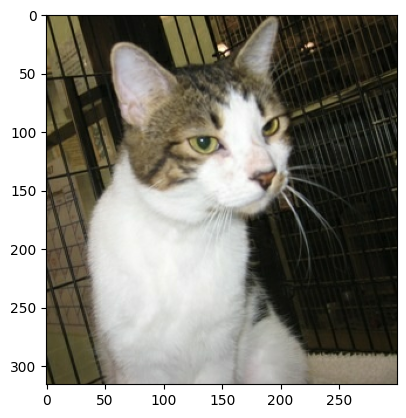

Classe: 1


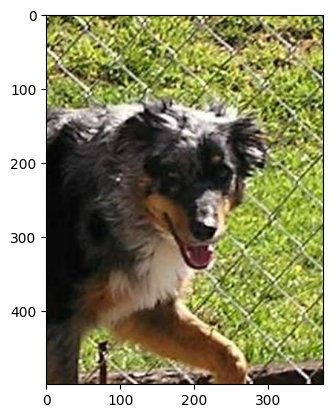

Classe: 1


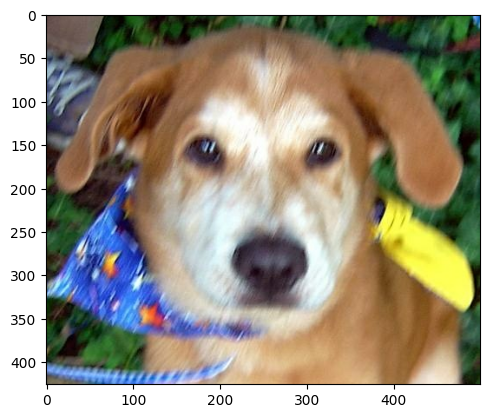

In [4]:
# Itera no conjunto de dados pegando exemplos
for data in train_data.take(3):
    image, label = data

    print("Classe: {}".format(label))
    plt.imshow(image)
    plt.show()

## Transfer learning

Carrega-se agora o VGG16 do Keras, treinado com ImageNet.


In [11]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Abaixo, congelaremos os pesos da rede, mantendo-se todas as camadas, exceto a última, que será substituída por uma camada softmax com 2 neurônios.

In [6]:
num_classes = 2

# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


A compilação é efetuada e resumo da rede pode ser observado abaixo:



In [7]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Agora, preparam-se os dados para retreinamento da rede. Os rótulos são classificados pelo método one-hot encoding e as imagens são redimensionadas para 224x224, têm os valores de cada pixel normalizados para entre 0 e 1, e seus valores são convertidos para float de 32 bits. Utilizaremos lotes 128 elementos.

In [8]:
# Dimensão das imagens usadas pela VGG
IMAGE_SIZE = (224, 224)

# Função usada para redimensionar e normalizar as imagens
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    label = tf.one_hot(label, num_classes)  # Converte o rótulo para "one-hot encoding"
    return  image, label

# Define tamanho do lote de dados de treinamento e validação
BATCH_SIZE = 128

# Cria lotes de dados usando o método map() para chamar a função format_image()
train_batches = train_data.map(format_image).batch(BATCH_SIZE)
test_batches = test_data.map(format_image).batch(BATCH_SIZE)
val_batches = val_data.map(format_image).batch(BATCH_SIZE)

# Verifique e ajuste os tipos de dados para evitar problemas no treinamento
train_batches = train_batches.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_batches = val_batches.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_batches = test_batches.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

In [9]:
for images, labels in train_batches.take(1):
    print(f"Shape das imagens: {images.shape}")
    print(f"Shape dos rótulos: {labels.shape}")


Shape das imagens: (128, 224, 224, 3)
Shape dos rótulos: (128, 2)


In [10]:
# Ajuste os buffers de pré-carregamento para desempenho
AUTOTUNE = tf.data.AUTOTUNE
train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)
val_batches = val_batches.prefetch(buffer_size=AUTOTUNE)
test_batches = test_batches.prefetch(buffer_size=AUTOTUNE)

# Treinamento
history2 = model_new.fit(
    train_batches,
    epochs=10,
    validation_data=val_batches,
)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 132s 757ms/step - accuracy: 0.7167 - loss: 0.5635 - val_accuracy: 0.8799 - val_loss: 0.3054
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 74s 575ms/step - accuracy: 0.8725 - loss: 0.3082 - val_accuracy: 0.8748 - val_loss: 0.2837
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 75s 589ms/step - accuracy: 0.8816 - loss: 0.2777 - val_accuracy: 0.8989 - val_loss: 0.2407
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 83s 649ms/step - accuracy: 0.8933 - loss: 0.2524 - val_accuracy: 0.8711 - val_loss: 0.2794
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 132s 567ms/step - accuracy: 0.8841 - loss: 0.2613 - val_accuracy: 0.9032 - val_loss: 0.2240
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 640ms/step - accuracy: 0.8960 - loss: 0.2412 - val_accuracy: 0.9080 - val_loss: 0.2117
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 75s 588ms/step - accuracy: 0.9031 - loss: 0.2276 - val_accuracy: 0.9138 - val_loss: 0.2066
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 77s 598ms/step - accuracy: 0.9016 - loss:

Abaixo, mostra-se a evolução da função de custo e do acurácia ao longo das épocas.

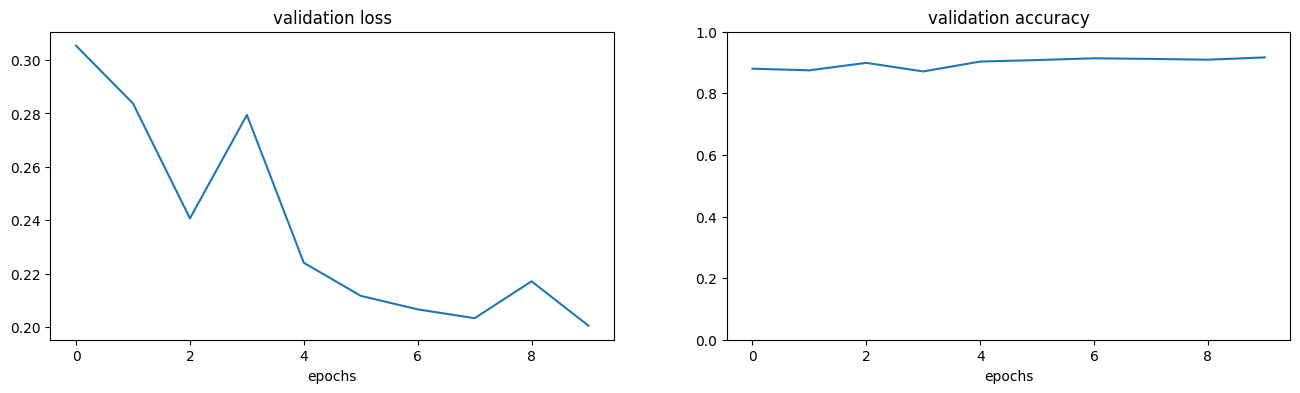

In [12]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)

ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Agora, a validação final nos dados de teste:

In [13]:
loss, accuracy = model_new.evaluate(test_batches, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.20275476574897766
Test accuracy: 0.9183146953582764


Abaixo farei uma predição para uma foto do meu cachorro:

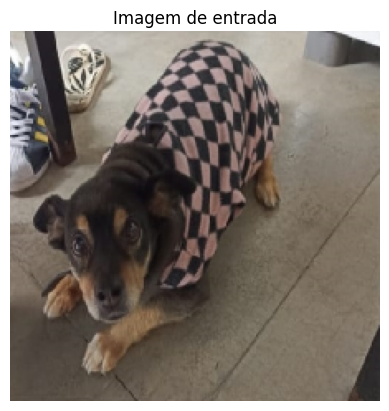

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Classe predita: Cachorro
Probabilidade: 0.66


In [19]:
from tensorflow.keras.utils import load_img, img_to_array

# Carregamento e pré-processamento da imagem
img_path = './fredinho.jpg'
img = load_img(img_path, target_size=IMAGE_SIZE)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Mostrar a imagem
plt.imshow(img)
plt.axis('off')  # Ocultar os eixos
plt.title("Imagem de entrada")
plt.show()

# Predição
predictions = model_new.predict(img_array)
predicted_class = np.argmax(predictions)  # Classe com maior probabilidade (0 = gato, 1 = cachorro)
probability = predictions[0][predicted_class]  # Probabilidade da classe predita

# Resultados
classes = ["Gato", "Cachorro"]
print(f"Classe predita: {classes[predicted_class]}")
print(f"Probabilidade: {probability:.2f}")